Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
## If you are using the data by mounting the google drive, use the following :
#from google.colab import drive
#drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
root_path = 'C:\\Users\\User\\Documents\\UpGRAD-ML\\9.CNN\\CNN_Assignment'  #change dir to your project folder

In [8]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("C:\\Users\\User\\Documents\\UpGRAD-ML\\9.CNN\\CNN_Assignment\\Train")
data_dir_test = pathlib.Path("C:\\Users\\User\\Documents\\UpGRAD-ML\\9.CNN\\CNN_Assignment\\Test")

In [9]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [10]:
batch_size = 32
img_height = 180
img_width = 180

Seeing the overall dataset and its distribution across classes

In [11]:
#Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
overall_ds = tf.keras.utils.image_dataset_from_directory(
  "C:\\Users\\User\\Documents\\UpGRAD-ML\\9.CNN\\CNN_Assignment\\Train",
  label_mode='int',
  labels='inferred',
  validation_split=0,
  #subset="fullset",
  shuffle=False,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 2239 files belonging to 9 classes.


Using 80% of the data for trainng and 20% for validation

In [12]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
  "C:\\Users\\User\\Documents\\UpGRAD-ML\\9.CNN\\CNN_Assignment\\Train",
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [13]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
  ,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [14]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [15]:
num_classes = len(class_names)
print(num_classes)

9


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

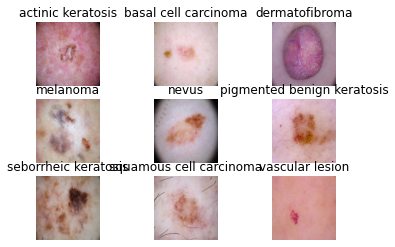

In [16]:
import matplotlib.pyplot as plt
### your code goes here, you can use training or validation data to visualize
for i in range(num_classes):
    filtered_ds = train_ds.filter(lambda x, l: tf.math.equal(l[0], i))
    for image, label in filtered_ds.take(1):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(image[0].numpy().astype('uint8'))
        plt.title(class_names[label.numpy()[0]])
        plt.axis('off')

In [17]:
class_count = np.zeros(num_classes, dtype=np.int32)
for images, labels in train_ds:
    y, _, c = tf.unique_with_counts(labels)
    class_count[y.numpy()] += c.numpy()
print(class_count)

[ 92 309  77 352 277 370  58 142 115]


In [18]:
class_count_val = np.zeros(num_classes, dtype=np.int32)
for images, labels in val_ds:
    y, _, c = tf.unique_with_counts(labels)
    class_count_val[y.numpy()] += c.numpy()
print(class_count_val)

[22 67 18 86 80 92 19 39 24]


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

In [19]:
#Confirming shape of image batch and the values of pixels
for image_batch, labels_batch in train_ds:
  first_image = image_batch[0]
  print(image_batch.shape)
  print(labels_batch.shape)
  print(np.min(first_image), np.max(first_image))
  break

(32, 180, 180, 3)
(32,)
0.0 255.0


`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [20]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [21]:
#Normalising the image
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)
train_ds_normal = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(train_ds_normal))
first_image = image_batch[0]
# Checking that the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))
# the train_ds_normal is being used only ofr checking the normalised value. A normalisation layer will be used in the model for the normalisation task

0.085098095 0.71699345


In [22]:
### Your code goes here
model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [23]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [24]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

### Train the model

In [25]:
epochs=20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 26s 442ms/step - loss: 1.8849 - accuracy: 0.3136 - val_loss: 1.6227 - val_accuracy: 0.4653
Epoch 2/20
56/56 [==============================] - 24s 422ms/step - loss: 1.6046 - accuracy: 0.4219 - val_loss: 1.5727 - val_accuracy: 0.4743
Epoch 3/20
56/56 [==============================] - 23s 407ms/step - loss: 1.4277 - accuracy: 0.5033 - val_loss: 1.3679 - val_accuracy: 0.5324
Epoch 4/20
56/56 [==============================] - 23s 412ms/step - loss: 1.3487 - accuracy: 0.5206 - val_loss: 1.4389 - val_accuracy: 0.5034
Epoch 5/20
56/56 [==============================] - 24s 422ms/step - loss: 1.2789 - accuracy: 0.5480 - val_loss: 1.4279 - val_accuracy: 0.5257
Epoch 6/20
56/56 [==============================] - 23s 420ms/step - loss: 1.1555 - accuracy: 0.5943 - val_loss: 1.3656 - val_accuracy: 0.5548
Epoch 7/20
56/56 [==============================] - 23s 418ms/step - loss: 1.1119 - accuracy: 0.6032 - val_loss: 1.7835 - val_accuracy: 0.4430

### Visualizing training results

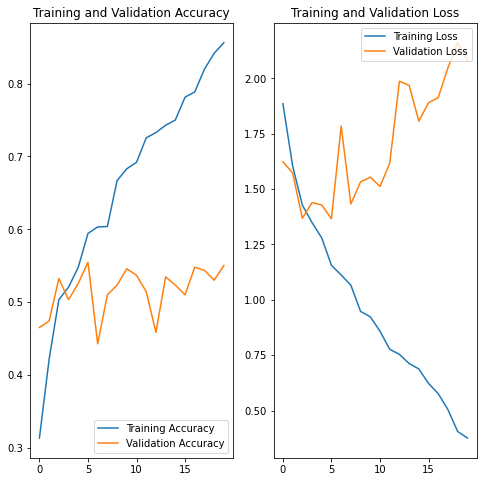

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

The model is OVERFITTING because:-

  Training accuracy improves with every epoch and reaches a final level of 0.91 which is very good. The loss in training also reduces with very epoch. Thus the model has learnt the training data well.

  However, the model does not perform well with validation data. The accuracy improves for some time and then plateaus out to about  0.55. The loss is seen to drop till the 3rd epoch and then it increases. Thus the model is unable to estimate the validation data correctly.

In [27]:
print(class_count)
print(class_count_val)

[ 92 309  77 352 277 370  58 142 115]
[22 67 18 86 80 92 19 39 24]


As can be seen, there are classes where there is not sufficient data. Thus data augmentaton is vital.

For the data augmentation, Rotation of Images and Clipping can be used. 

It is not advisable to change colour/ brightness as that is vital iformation for classifiction of the problem.

In [28]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here
Augmentation_Layers = keras.Sequential(
  [
    layers.RandomFlip("horizontal_and_vertical",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.2),
    layers.RandomRotation(0.4),
    layers.RandomZoom(0.2),
  ]
)

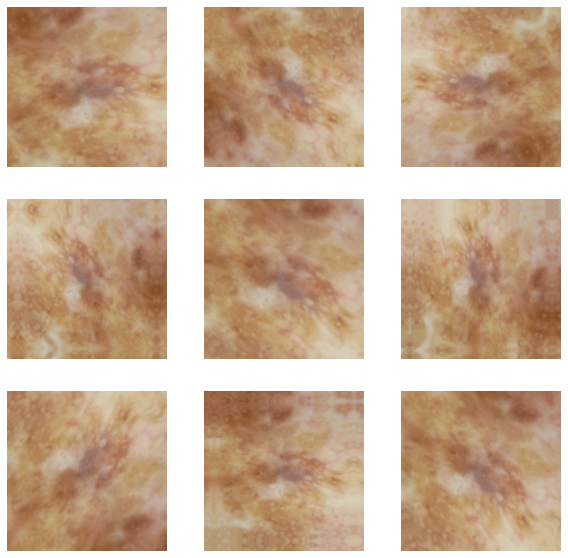

In [29]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = Augmentation_Layers(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [30]:
## You can use Dropout layer if there is an evidence of overfitting in your findings
# As we have seen evidence of overfitting a dropoutof 0.2 will be used
## Your code goes here
model = Sequential([
  Augmentation_Layers,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])


### Compiling the model

In [31]:
## Your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [32]:
## Your code goes here, note: train your model for 30 epochs
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
56/56 [==============================] - 28s 492ms/step - loss: 2.0561 - accuracy: 0.2366 - val_loss: 1.8428 - val_accuracy: 0.3266
Epoch 2/30
56/56 [==============================] - 29s 515ms/step - loss: 1.8466 - accuracy: 0.3175 - val_loss: 1.6860 - val_accuracy: 0.3870
Epoch 3/30
56/56 [==============================] - 30s 544ms/step - loss: 1.7168 - accuracy: 0.3839 - val_loss: 1.6134 - val_accuracy: 0.4340
Epoch 4/30
56/56 [==============================] - 30s 539ms/step - loss: 1.5247 - accuracy: 0.4609 - val_loss: 1.5480 - val_accuracy: 0.4362
Epoch 5/30
56/56 [==============================] - 29s 518ms/step - loss: 1.4915 - accuracy: 0.4643 - val_loss: 1.3822 - val_accuracy: 0.5145
Epoch 6/30
56/56 [==============================] - 29s 520ms/step - loss: 1.3970 - accuracy: 0.5134 - val_loss: 1.4067 - val_accuracy: 0.5257
Epoch 7/30
56/56 [==============================] - 29s 518ms/step - loss: 1.4233 - accuracy: 0.5117 - val_loss: 1.3622 - val_accuracy: 0.5347

### Visualizing the results

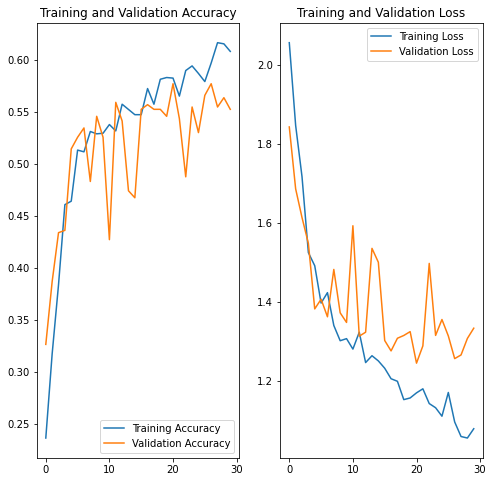

In [33]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

There is a slight improvement in the model with addition of the augmentation layer. The model performance shows the improvement in terms of overftting, but the overall low accuracy indicates that the model is now underfitting because of probable class imbalance 

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [34]:
## Your code goes here.
class_count = np.zeros(num_classes, dtype=np.int32)
for images, labels in train_ds:
    y, _, c = tf.unique_with_counts(labels)
    class_count[y.numpy()] += c.numpy()
print(class_count)

[ 92 309  77 352 277 370  58 142 115]


[Text(-0.1, 0, 'actinic keratosis'),
 Text(0.9, 0, 'basal cell carcinoma'),
 Text(1.9, 0, 'dermatofibroma'),
 Text(2.9, 0, 'melanoma'),
 Text(3.9, 0, 'nevus'),
 Text(4.9, 0, 'pigmented benign keratosis'),
 Text(5.9, 0, 'seborrheic keratosis'),
 Text(6.9, 0, 'squamous cell carcinoma'),
 Text(7.9, 0, 'vascular lesion')]

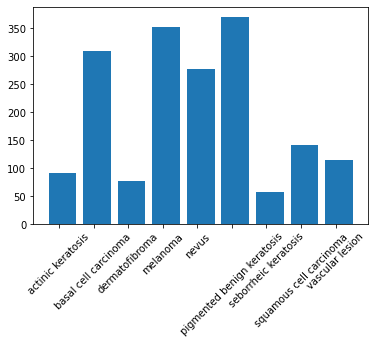

In [35]:
fig,ax = plt.subplots()
rects = ax.bar(class_names, class_count)
ax.set_xticks([ind-0.1 for ind in range(num_classes)])
ax.set_xticklabels(class_names, rotation = (45))

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
     Seborrheric Keratosis has the least number of samples
#### - Which classes dominate the data in terms proportionate number of samples?
    Basal Cell Carcinoma, Melanoma, Pigmented Benign Keratosis domnate the data in terms of proportion of number of samples


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [36]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [39]:
path_to_training_dataset="C:\\Users\\User\\Documents\\UpGRAD-ML\\9.CNN\\CNN_Assignment\\Train\\"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to C:\Users\User\Documents\UpGRAD-ML\9.CNN\CNN_Assignment\Train\actinic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x24A04230BB0>: 100%|██████████| 500/500 [00:05<00:00, 84.25 Samples/s]                   


Initialised with 376 image(s) found.
Output directory set to C:\Users\User\Documents\UpGRAD-ML\9.CNN\CNN_Assignment\Train\basal cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x24A048E9340>: 100%|██████████| 500/500 [00:07<00:00, 69.26 Samples/s]                  


Initialised with 95 image(s) found.
Output directory set to C:\Users\User\Documents\UpGRAD-ML\9.CNN\CNN_Assignment\Train\dermatofibroma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x24A0F1CC850>: 100%|██████████| 500/500 [00:07<00:00, 64.29 Samples/s]                  


Initialised with 438 image(s) found.
Output directory set to C:\Users\User\Documents\UpGRAD-ML\9.CNN\CNN_Assignment\Train\melanoma\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x24A0A3F38B0>: 100%|██████████| 500/500 [00:30<00:00, 16.52 Samples/s]                   


Initialised with 357 image(s) found.
Output directory set to C:\Users\User\Documents\UpGRAD-ML\9.CNN\CNN_Assignment\Train\nevus\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x24A049243D0>: 100%|██████████| 500/500 [00:25<00:00, 19.67 Samples/s]                    


Initialised with 462 image(s) found.
Output directory set to C:\Users\User\Documents\UpGRAD-ML\9.CNN\CNN_Assignment\Train\pigmented benign keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x24A04935AC0>: 100%|██████████| 500/500 [00:06<00:00, 82.64 Samples/s]                   


Initialised with 77 image(s) found.
Output directory set to C:\Users\User\Documents\UpGRAD-ML\9.CNN\CNN_Assignment\Train\seborrheic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x24A6D0281C0>: 100%|██████████| 500/500 [00:12<00:00, 38.92 Samples/s]                  


Initialised with 181 image(s) found.
Output directory set to C:\Users\User\Documents\UpGRAD-ML\9.CNN\CNN_Assignment\Train\squamous cell carcinoma\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x24A049356A0>: 100%|██████████| 500/500 [00:06<00:00, 81.35 Samples/s]


Initialised with 139 image(s) found.
Output directory set to C:\Users\User\Documents\UpGRAD-ML\9.CNN\CNN_Assignment\Train\vascular lesion\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x24A6E462D00>: 100%|██████████| 500/500 [00:05<00:00, 85.27 Samples/s]                  


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [40]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [48]:
import glob
path_list = [x for x in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['C:\\Users\\User\\Documents\\UpGRAD-ML\\9.CNN\\CNN_Assignment\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_4d2a6a99-af81-42ac-b570-0b1316d95aa6.jpg',
 'C:\\Users\\User\\Documents\\UpGRAD-ML\\9.CNN\\CNN_Assignment\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_60652382-7431-43d9-8a06-f3eeebc05fe3.jpg',
 'C:\\Users\\User\\Documents\\UpGRAD-ML\\9.CNN\\CNN_Assignment\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_7047772a-2e2a-4994-b00a-f40670a1dc30.jpg',
 'C:\\Users\\User\\Documents\\UpGRAD-ML\\9.CNN\\CNN_Assignment\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_7405fdc5-2fcc-4ab6-a5e8-c4db307901be.jpg',
 'C:\\Users\\User\\Documents\\UpGRAD-ML\\9.CNN\\CNN_Assignment\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_c1e23f41-8d86-4cf9-b3b6-9a995948c7da.jpg',
 'C:\\Users\\User\\Documents\\UpGRAD-ML\\9.CNN\\CNN_Assignment\\Train\\acti

In [49]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [51]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [54]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
#new_df = original_df.append(df2)

In [55]:
#new_df['Label'].value_counts()

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [56]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [60]:
data_dir_train="C:\\Users\\User\\Documents\\UpGRAD-ML\\9.CNN\\CNN_Assignment\\Train"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [62]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [63]:
## your code goes here
### Your code goes here
model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [64]:
## your code goes here
## Your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [65]:
## Your code goes here, use 50 epochs.
epochs = 50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
169/169 [==============================] - 77s 450ms/step - loss: 1.7767 - accuracy: 0.3247 - val_loss: 1.4551 - val_accuracy: 0.4662
Epoch 2/50
169/169 [==============================] - 81s 477ms/step - loss: 1.3624 - accuracy: 0.4870 - val_loss: 1.3111 - val_accuracy: 0.5160
Epoch 3/50
169/169 [==============================] - 82s 482ms/step - loss: 1.1732 - accuracy: 0.5655 - val_loss: 1.1018 - val_accuracy: 0.6117
Epoch 4/50
169/169 [==============================] - 82s 483ms/step - loss: 0.9577 - accuracy: 0.6536 - val_loss: 0.9883 - val_accuracy: 0.6451
Epoch 5/50
169/169 [==============================] - 82s 482ms/step - loss: 0.7488 - accuracy: 0.7294 - val_loss: 0.9003 - val_accuracy: 0.6986
Epoch 6/50
169/169 [==============================] - 82s 482ms/step - loss: 0.6090 - accuracy: 0.7797 - val_loss: 0.8809 - val_accuracy: 0.7105
Epoch 7/50
169/169 [==============================] - 83s 488ms/step - loss: 0.4853 - accuracy: 0.8290 - val_loss: 0.8182 - val_ac

#### **Todo:**  Visualize the model results

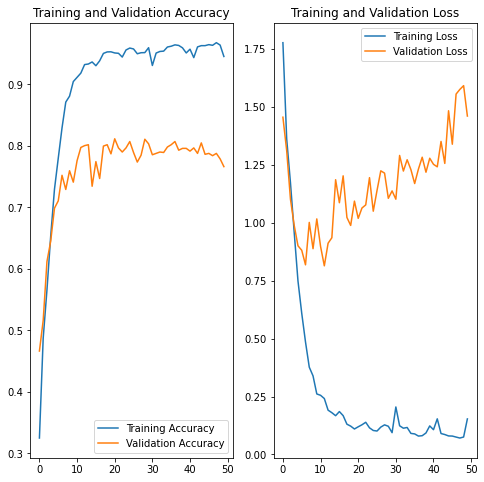

In [66]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



The model with augmented dataset shows much better performance. 
The training accuracy has improved ad keeps improving with higher number of epochs.
The valdation accuracy increases to a certain exgtent and then it plateaus out. However with augmentation the accuracy of the model for the validation data has improved from around 0.6 to 0.8.
Thus class rebalance has definitely aided the performance of the model.